In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f281193761e28f18f29458ebb7686253da0a3a42afcbe128d6681b580261d249
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Logistic Regression

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob


spark = SparkSession.builder \
    .appName("SentimentAnalysis") \
    .getOrCreate()


sentiment_df = spark.read.csv("Sentiment.csv", header=True)


sentiment_df = sentiment_df.drop("candidate", "sentiment", "sentiment_confidence",
                                 "candidate_gold", "name", "relevant_yn_gold",  "sentiment_gold",
                                 "subject_matter_gold",  "tweet_id", "user_timezone")

sentiment_df = sentiment_df.filter(~sentiment_df['text'].startswith("RT"))
sentiment_df = sentiment_df.dropDuplicates(['text'])
sentiment_df = sentiment_df.withColumn("text", regexp_replace(sentiment_df["text"], r"http\S+", ""))
sentiment_df = sentiment_df.withColumn("text", regexp_replace(sentiment_df["text"], r"[^\w\s]", ""))

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
sentiment_df = tokenizer.transform(sentiment_df)

stop_words_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
sentiment_df = stop_words_remover.transform(sentiment_df)

def get_sentiment(text):
    analysis = TextBlob(text)
    sentiment_polarity = analysis.sentiment.polarity
    if sentiment_polarity > 0:
        return "positive"
    elif sentiment_polarity < 0:
        return "negative"
    else:
        return "neutral"

sentiment_udf = udf(get_sentiment, StringType())
sentiment_df = sentiment_df.withColumn("sentiment", sentiment_udf(col("text")))
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")
sentiment_df = label_indexer.fit(sentiment_df).transform(sentiment_df)

hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features")
sentiment_df = hashing_tf.transform(sentiment_df)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(sentiment_df)
sentiment_df = idf_model.transform(sentiment_df)

train_data, test_data = sentiment_df.randomSplit([0.7, 0.3], seed=42)

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")

logistic_regression_model = logistic_regression.fit(train_data)

predictions = logistic_regression_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

sentiment_df.show()

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, expr


evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")


accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)



Accuracy: 0.686294945284002
+-----+--------------------+-----------+----------------------+--------------------+-------------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+--------------------+--------------------+
|   id|candidate_confidence|relevant_yn|relevant_yn_confidence|      subject_matter|subject_matter_confidence|retweet_count|                text|         tweet_coord|       tweet_created|      tweet_location|              tokens|     filtered_tokens|sentiment|label|        raw_features|            features|
+-----+--------------------+-----------+----------------------+--------------------+-------------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----+--------------------+--------------------+
| 7133|                 1.0|        yes|     

Mean Squared Error (MSE): 1.300486417446905
Root Mean Squared Error (RMSE): 1.1403887133109065


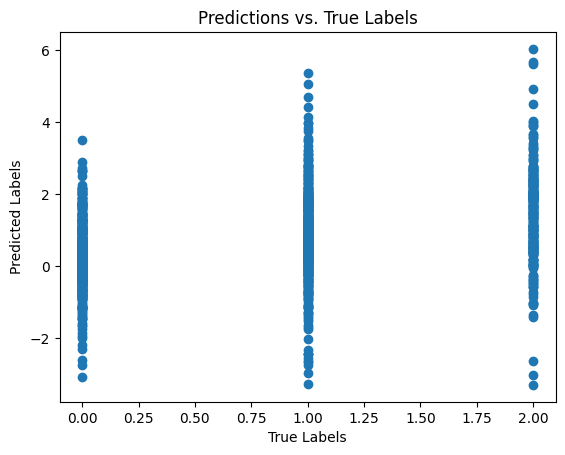

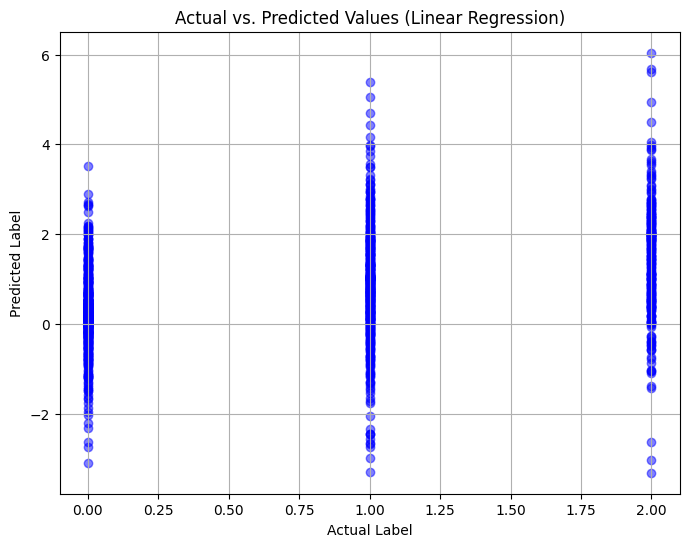

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.feature import VectorAssembler
sentiment_df = sentiment_df.withColumn("candidate_confidence", col("candidate_confidence").cast("double"))
feature_columns = ["candidate_confidence"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features1")
assembled_data = assembler.transform(sentiment_df)


(train_data, test_data) = assembled_data.randomSplit([0.8, 0.2], seed=1234)

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)


evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

predictions_pd = predictions.select("label", "prediction").toPandas()
plt.scatter(predictions_pd["label"], predictions_pd["prediction"])
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Predictions vs. True Labels")
plt.show()

actual = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()


plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, color='blue', alpha=0.5)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.show()


plt.show()




spark.stop()


# K means

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

selected_cols = ["candidate_confidence", "relevant_yn_confidence", "retweet_count"]

sentiment_df = sentiment_df.withColumn("candidate_confidence", sentiment_df["candidate_confidence"].cast("double"))
sentiment_df = sentiment_df.withColumn("relevant_yn_confidence", sentiment_df["relevant_yn_confidence"].cast("double"))
sentiment_df = sentiment_df.withColumn("retweet_count", sentiment_df["retweet_count"].cast("double"))

assembler_kmeans = VectorAssembler(inputCols=selected_cols, outputCol="features_kmeans")
sentiment_df = assembler_kmeans.transform(sentiment_df)

scaler = StandardScaler(inputCol="features_kmeans", outputCol="scaled_features")
scaler_model = scaler.fit(sentiment_df)
sentiment_df = scaler_model.transform(sentiment_df)

kmeans = KMeans().setK(3).setSeed(42)
model = kmeans.fit(sentiment_df)

clustered_data = model.transform(sentiment_df)

clustered_data.select("features_kmeans", "prediction").show()






+-------------------+----------+
|    features_kmeans|prediction|
+-------------------+----------+
|      [1.0,1.0,9.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|[0.4568,0.6759,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,2.0]|         0|
|[0.4379,0.6617,0.0]|         0|
|[0.3735,0.6111,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,1.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,2.0]|         0|
|[0.4299,0.6557,0.0]|         0|
|   [0.6707,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
|      [1.0,1.0,0.0]|         0|
+-------------------+----------+
only showing top 20 rows



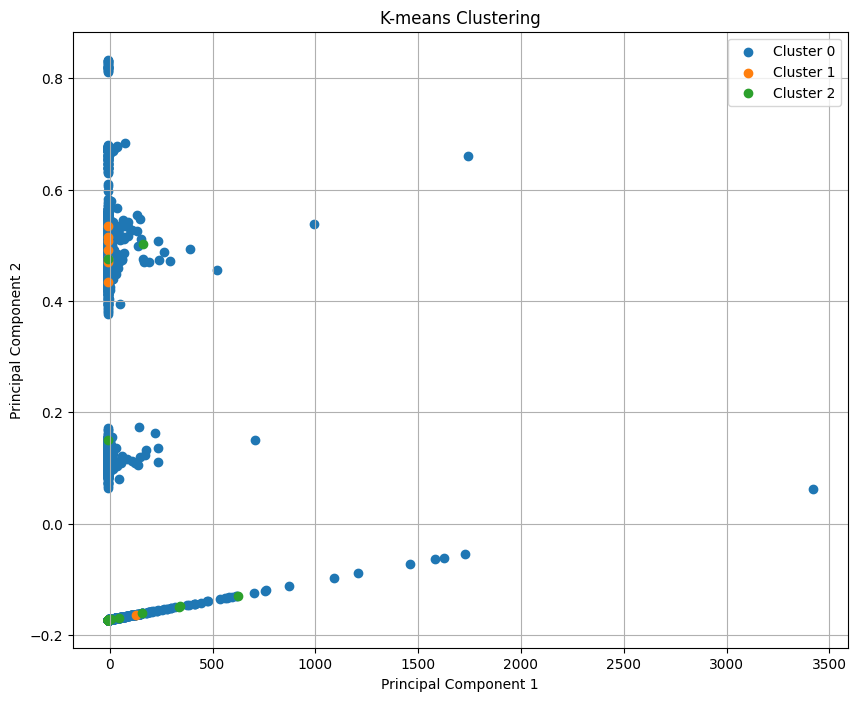

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd


pandas_df = clustered_data.select("features_kmeans", "prediction").toPandas()


features = pandas_df["features_kmeans"].tolist()
predictions = pandas_df["prediction"].tolist()


pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)
principal_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])


principal_df["prediction"] = predictions

plt.figure(figsize=(10, 8))
for cluster in range(3):
    cluster_data = principal_df[principal_df["prediction"] == cluster]
    plt.scatter(cluster_data["PC1"], cluster_data["PC2"], label=f"Cluster {cluster}")

plt.title("K-means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


# Batch Gradient

In [1]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol="label", featuresCol="features")

pipeline = Pipeline(stages=[hashingTF, idf, lr])

(trainingData, testData) = df_indexed.randomSplit([0.8, 0.2], seed=123)

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = {:.2f}%".format(accuracy * 100))




test accuracy : 37.8


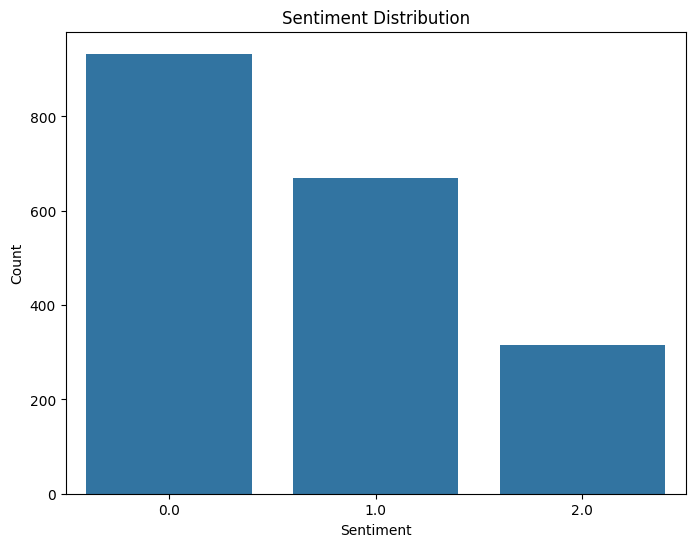

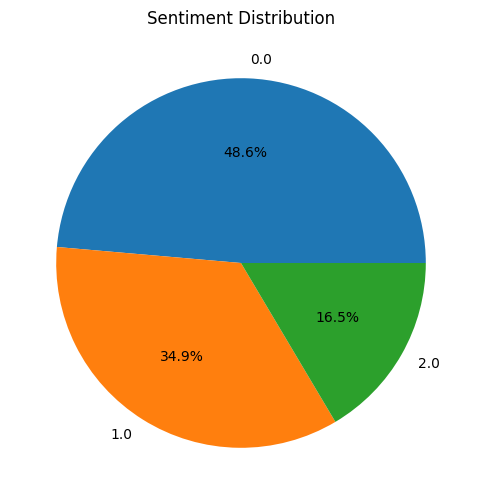

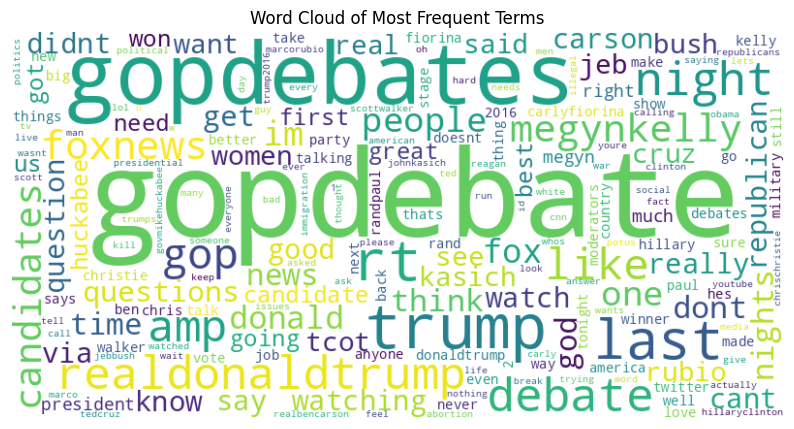

<ipython-input-3-87143d7980f2>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=top_words, palette='viridis')


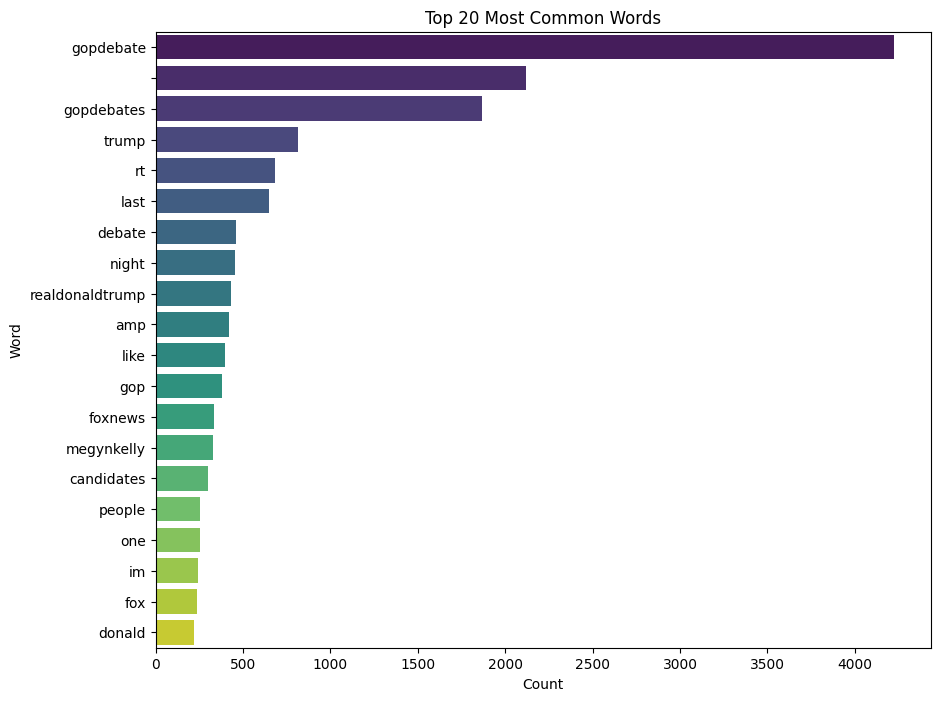

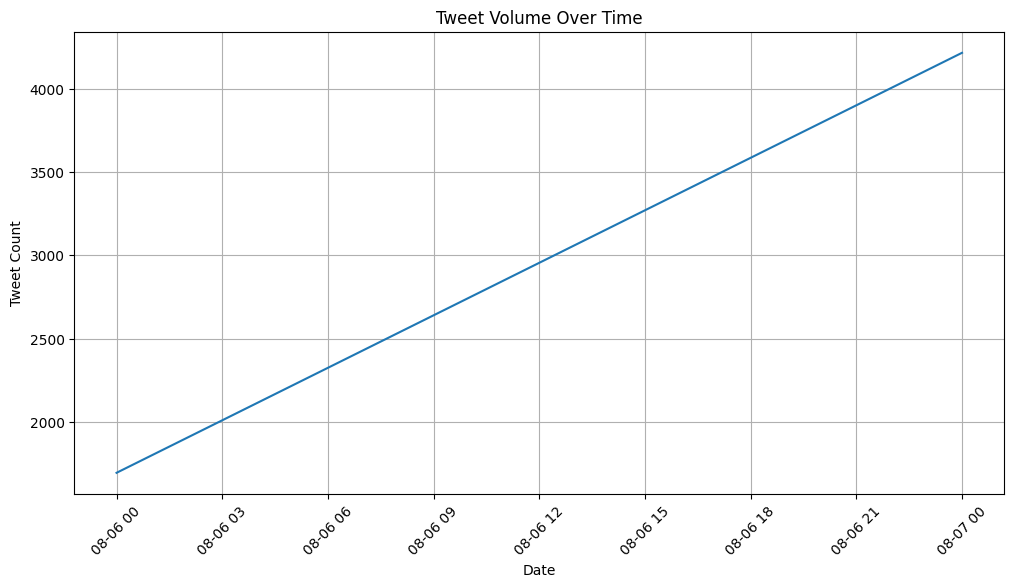

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd

sentiment_distribution = predictions.select("prediction").toPandas()


plt.figure(figsize=(8, 6))
sns.countplot(x="prediction", data=sentiment_distribution)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8, 6))
sentiment_distribution['prediction'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()


word_counts = sentiment_df.select("filtered_tokens").rdd.flatMap(lambda x: x.filtered_tokens).countByValue()
word_cloud_data = {word: count for word, count in word_counts.items() if count > 10}

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_cloud_data)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Terms")
plt.show()


top_n = 20
top_words = pd.DataFrame(list(word_cloud_data.items()), columns=['Word', 'Count']).nlargest(top_n, 'Count')

plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Word', data=top_words, palette='viridis')
plt.title(f"Top {top_n} Most Common Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


tweet_volume = sentiment_df.select("tweet_created").toPandas()

tweet_volume['tweet_created'] = pd.to_datetime(tweet_volume['tweet_created'], errors='coerce')


tweet_volume['date'] = tweet_volume['tweet_created'].dt.date

tweet_volume = tweet_volume.groupby('date').size().reset_index(name='tweet_count')

plt.figure(figsize=(12, 6))
plt.plot(tweet_volume['date'], tweet_volume['tweet_count'])
plt.title("Tweet Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


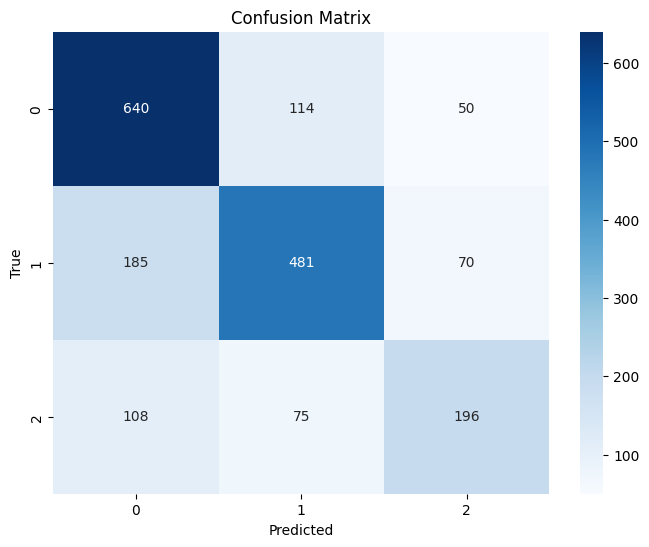

In [ ]:
from sklearn.metrics import confusion_matrix
true_labels = test_data.select("label").rdd.map(lambda row: row.label).collect()
predicted_labels = predictions.select("prediction").rdd.map(lambda row: row.prediction).collect()

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

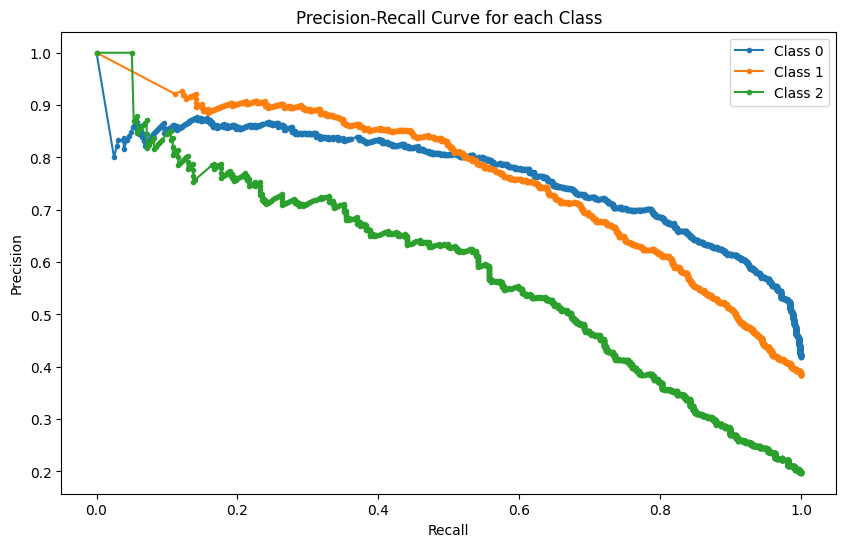

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

predictions_pd = predictions.select(['label', 'probability']).toPandas()

probabilities = np.array(predictions_pd['probability'].tolist())

precision_list = []
recall_list = []

for class_index in range(probabilities.shape[1]):
    precision, recall, _ = precision_recall_curve(predictions_pd['label'], probabilities[:, class_index], pos_label=class_index)
    precision_list.append(precision)
    recall_list.append(recall)

plt.figure(figsize=(10, 6))
for class_index in range(probabilities.shape[1]):
    plt.plot(recall_list[class_index], precision_list[class_index], marker='.', label='Class {}'.format(class_index))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each Class')
plt.legend()
plt.show()
